In [1]:
# Import libraries
import pandas as pd
import geopandas as gpd
# Operations on geometries
import shapely
import numpy as np
from numpy import nan
import math
import glob 
import xarray as xr
import xarray
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import tensorflow as tf
import statsmodels.api as sm
import xgboost
import xgboost as xgb
import csv as csv
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn import linear_model
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor  #Perforing grid search
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn import datasets, metrics, model_selection
from yellowbrick.regressor import residuals_plot


import scipy
from scipy import stats
import os

import matplotlib.pyplot as plt

from scipy.stats import skew
from collections import OrderedDict

# To make this notebook's output stable across runs
np.random.seed(42)

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder

from utils_functions.utils_data import *
from utils_functions.utils_ml import *
from utils_functions.utils_RF import *

from utils_functions.utils_plot import *

/Users/noeliaotero/opt/anaconda3/envs/py39/lib/python3.9/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
PATH = '/Users/noeliaotero/Documents/OCCR/data/Output_data/csv/tomodel_Level_reservoirs/'

In [3]:
PATH_data_out = '/Users/noeliaotero/Documents/OCCR/data/Output_data/csv/outmodels_resevervoirs/simulations_PREVAH/Classical/'
os.makedirs(PATH_data_out, exist_ok=True)


In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = '/Users/noeliaotero/Documents/OCCR/Results/Hydro_project/Analysis_Updates_June/Reservoir_levels/'

#PROJECT_ROOT_DIR = '/Users/noeliaotero/Documents/OCCR/Results/Hydro_project/Analysis_Updates_June/ClassicalModels_Prevah_withdoi/'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

In [5]:
df = pd.read_csv(PATH + 'df_valais_2000-2021.csv',index_col=0)
df.columns

Index(['date', 't2m', 't2mmax', 'precip', 'PREVAH', 'storage_percent',
       'storage_gwh', 'storage_max_gwh', 'day', 'week', 'prec2W', 'prec4W',
       'prec6W', 't2max2W', 't2max4W', 't2max6W', 't2m2W', 't2m4W', 't2m6W',
       'PREVAH2W', 'PREVAH4W', 'PREVAH6W'],
      dtype='object')

In [6]:
df.tail()

,date,t2m,t2mmax,precip,PREVAH,storage_percent,storage_gwh,storage_max_gwh,day,week,...,prec6W,t2max2W,t2max4W,t2max6W,t2m2W,t2m4W,t2m6W,PREVAH2W,PREVAH4W,PREVAH6W
1144,2021-11-29,-7.637549,-4.314431,6.212080,0.916519,0.647407,2622,4050,Monday,48,...,2.548584,-4.992965,-2.245791,-0.767934,-8.145489,-5.314420,-3.893576,0.963034,0.956374,0.985234
1145,2021-12-06,-8.653429,-5.671498,6.233881,1.009548,0.604938,2450,4050,Monday,49,...,4.592300,-1.408953,-1.740673,-0.928218,-4.581211,-4.924116,-4.039478,0.970344,0.936856,1.358761
1146,2021-12-13,-0.508993,2.853591,0.025810,0.931140,0.568395,2302,4050,Monday,50,...,5.112013,1.511619,0.148987,-0.743697,-1.702744,-3.035402,-3.955831,0.910678,1.566939,1.436855
1147,2021-12-20,-2.896494,0.169647,0.309590,0.890216,0.533827,2162,4050,Monday,51,...,4.836997,1.706927,2.089149,0.148987,-1.489593,-1.162726,-3.035402,2.163534,1.752736,1.566939
1148,2021-12-27,-0.082692,3.244207,12.778706,3.436853,0.514568,2084,4050,Monday,52,...,4.371369,3.244207,1.706927,2.089149,-0.082692,-1.489593,-1.162726,3.436853,2.163534,1.752736


In [7]:
YY_TRAIN = [2000, 2016]
YY_TEST  = [2017,2021]

In [8]:
# ------No temperature 

colnames = ['date', 't2m','prec', 'prec7D', 'prec15D', 'prec30D', 't2m7D', 't2m15D',
       't2m30D','PREVAH','PREVAH7D', 'PREVAH15D', 'PREVAH30D','doi']
# Adding doi
Features = ['t2m','t2m2W','t2m4W', 't2m6W','precip', 'prec2W', 'prec4W',
       'prec6W','PREVAH','PREVAH2W', 'PREVAH4W', 'PREVAH6W', 'week']

label = 'storage_gwh'

In [9]:
df["date"] = pd.to_datetime(df["date"])
# add day of the year
df['doi'] = df.date.dt.dayofyear

In [10]:
# split data 
train_dataset = df[(df.date.dt.year >= YY_TRAIN[0]) & (df.date.dt.year <= YY_TRAIN[1])]
test_dataset = df[(df.date.dt.year >= YY_TEST[0]) & (df.date.dt.year <= YY_TEST[1])]
train_dates = train_dataset['date']
test_dates = test_dataset['date']

In [11]:
# Prepare the data to model
# select columns
x_train = train_dataset[Features]
y_train = train_dataset[label]
# test
x_test = test_dataset[Features]
y_test = test_dataset[label]

In [12]:
# Normalise the data
fpipeline = prepareData(x_train)
X_train_in = fpipeline.fit_transform(x_train)
X_test_in = fpipeline.transform(x_test)
# Check and fill NA if needed
y_train = y_train.copy()
train_median = y_train.median()
y_train.fillna(train_median, inplace=True)
    
y_test = y_test.copy()
test_median = y_test.median()
y_test.fillna(test_median, inplace=True)

In [13]:
df_out = pd.DataFrame(columns = ['station', 'model', 'train_rmse', 'test_rmse','train_mae', 'test_mae', 'train_score', 'test_score','cor_train','cor_test'])

In [14]:
##%matplotlib agg
models =['linear','randomforest','rf_Predefinesplit']
methods = ['RandomizedSearch']  
l_mod = []
all_models = []
all_data = []
l_fpipeline = []
plot=True
name_s = 'Valais'

In [15]:
yy_tot = np.append(train_dates.dt.year, test_dates.dt.year)
yy = np.unique(yy_tot, return_counts=False)

linear
Model r-sq mean: 0.6270859642478082
 RMSE: 657.592542
 RMSE: 670.046618
Saving figure Valais_lineartest
Saving figure Valais_lineartrain
Saving figure Valais_linearFeature_IMPORT
plotting residuals for Valais
model linear


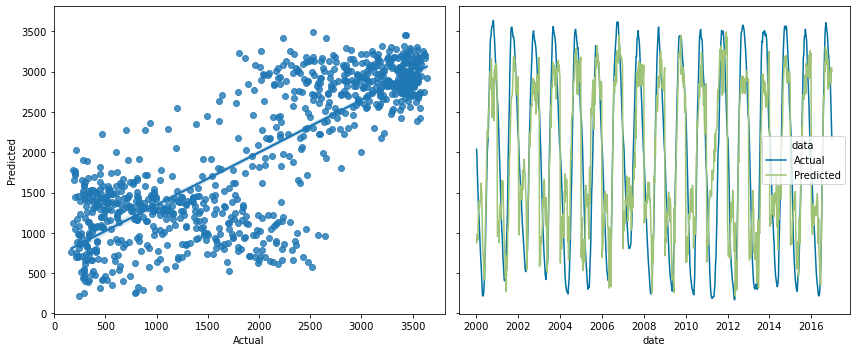

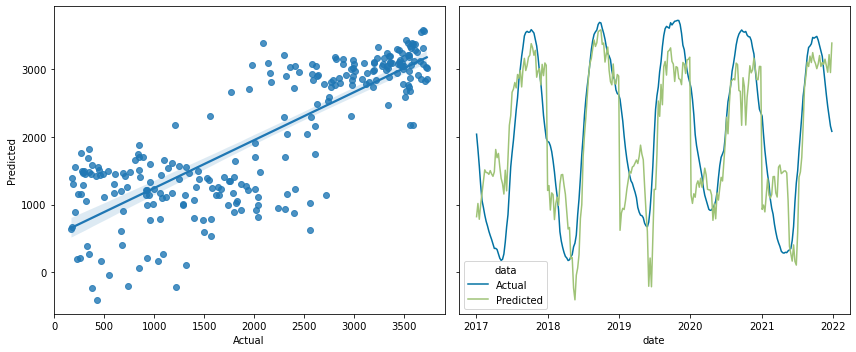

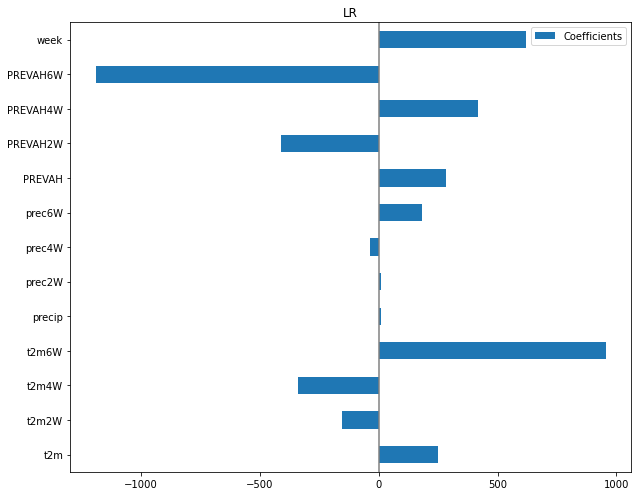

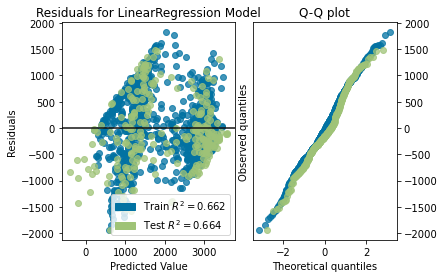

randomforest


/Users/noeliaotero/Documents/OCCR/scripts/jupyter.notes/Hydropower/utils_functions/utils_RF.py:260: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(-mean_score), params)


nan {'n_estimators': 5, 'max_features': 'sqrt', 'max_depth': 14}
nan {'n_estimators': 10, 'max_features': 'sqrt', 'max_depth': 10}
nan {'n_estimators': 3, 'max_features': 'auto', 'max_depth': 14}
nan {'n_estimators': 5, 'max_features': 'auto', 'max_depth': 12}
nan {'n_estimators': 3, 'max_features': 'auto', 'max_depth': 10}
nan {'n_estimators': 5, 'max_features': 'auto', 'max_depth': 10}
nan {'n_estimators': 8, 'max_features': 'sqrt', 'max_depth': 14}
nan {'n_estimators': 5, 'max_features': 'auto', 'max_depth': 14}
nan {'n_estimators': 3, 'max_features': 'sqrt', 'max_depth': 10}
nan {'n_estimators': 3, 'max_features': 'auto', 'max_depth': 8}
Score train: 0.9903
Score test: 0.9793
 RMSE: 111.734680
 RMSE: 166.569938
Saving figure Valais_randomforesttest
Saving figure Valais_randomforesttrain
Saving figure Valais_randomforestFeature_IMPORT
plotting residuals for Valais
model randomforest


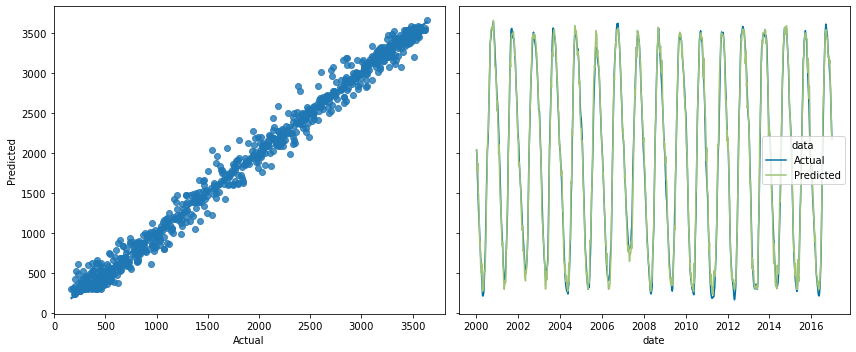

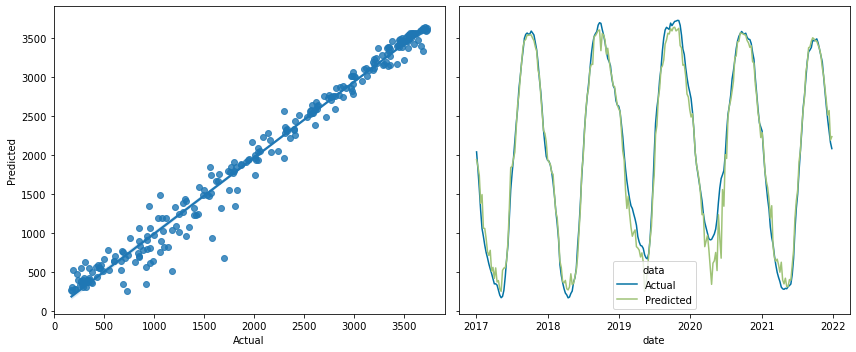

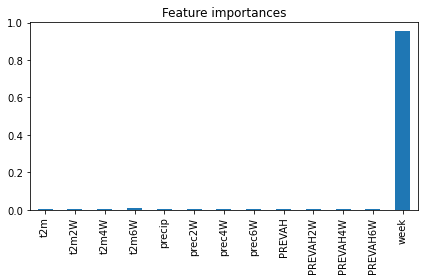

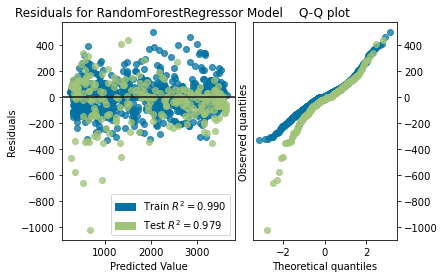

rf_Predefinesplit
Tuned RF params: <bound method BaseEstimator.set_params of RandomForestRegressor(max_depth=14, max_features=6, n_estimators=5)>
Tuned RF Score:  0.9878929055331318
Tuned RF Score:  0.9781033277575265
 RMSE: 124.537314
 RMSE: 171.139882
Saving figure Valais_rf_Predefinesplittest
Saving figure Valais_rf_Predefinesplittrain
Saving figure Valais_rf_PredefinesplitFeature_IMPORT
plotting residuals for Valais
model rf_Predefinesplit


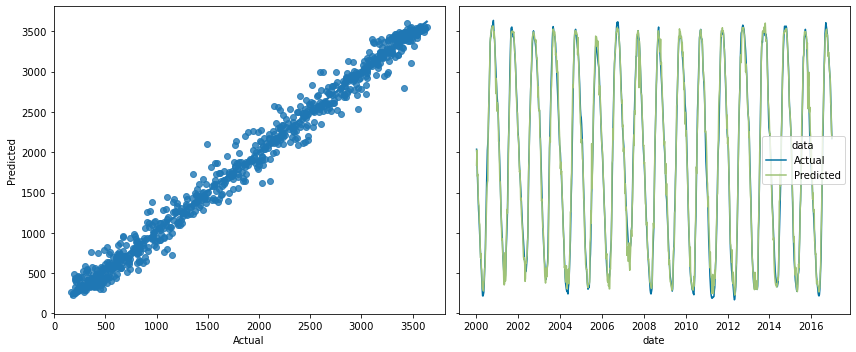

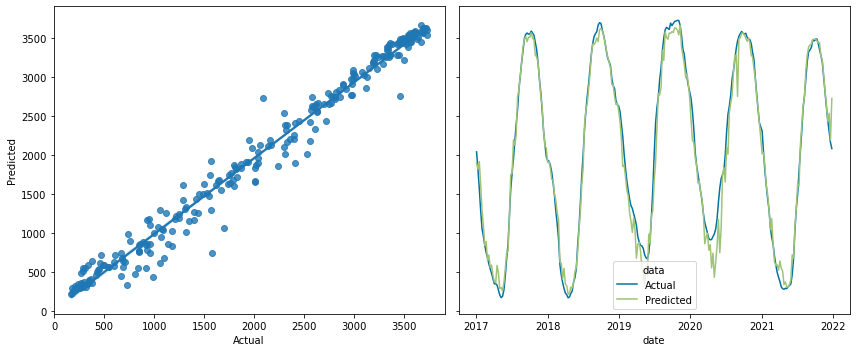

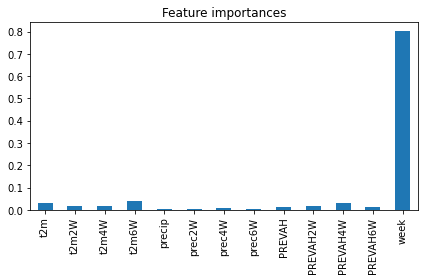

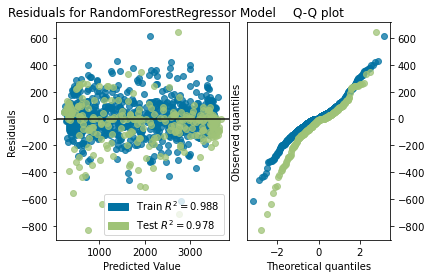

In [16]:
# Run the models
for imod in range(0,len(models)):
    print(models[imod])
        
    if models[imod] == 'linear':
        r=Classicalmodels(models[imod],X_train_in, y_train, X_test_in, y_test, yy, Features, None, csv = True)
    elif models[imod] == 'randomforest':
        r=Classicalmodels(models[imod],X_train_in, y_train, X_test_in, y_test, yy, Features, methods[0], csv = False)
    elif models[imod] == 'rf_Predefinesplit':
        r=Classicalmodels(models[imod],X_train_in, y_train, X_test_in, y_test, yy, Features, None, csv = False)
            
    pred_test = r.model.predict(X_test_in)
    pred_train = r.model.predict(X_train_in)
    rmse_train = evaluate_model(y_train, pred_train)
    rmse_test = evaluate_model(y_test, pred_test)
    mae_train = mean_absolute_error(y_train, pred_train)
    mae_test = mean_absolute_error(y_test, pred_test)
    # add scores
    train_score = r.model.score(X_train_in, y_train)
    test_score = r.model.score(X_test_in, y_test)
        

    df_out = df_out.append({'station': name_s}, ignore_index=True)
    df_out.at[df_out.index[-1],'model'] = models[imod]
    df_out.at[df_out.index[-1], 'train_rmse'] = rmse_train
    df_out.at[df_out.index[-1], 'test_rmse'] = rmse_test
    df_out.at[df_out.index[-1], 'train_mae'] = mae_train
    df_out.at[df_out.index[-1], 'test_mae'] = mae_test
    df_out.at[df_out.index[-1], 'train_score'] = train_score
    df_out.at[df_out.index[-1], 'test_score'] = test_score
       

    # add also the correlations between predicted and observed
    cor_train = stats.pearsonr(pred_train, y_train)[0]
    cor_test = stats.pearsonr(pred_test, y_test)[0]
    df_out.at[df_out.index[-1], 'cor_train'] = cor_train
    df_out.at[df_out.index[-1], 'cor_test'] = cor_test
    
    # storage the predictions
    p1 = pd.DataFrame(pred_train)
    p2 = pd.DataFrame(pred_test)
    allpred = p1.append(p2)
    df[models[imod]] = allpred.values
        
    l_mod.append(r)
    
    # plot model outputs
    
    fig_train = 'Valais_' + models[imod] + 'test' 
    plot_moutput(train_dates, y_train, pred_train, fig_train, IMAGES_PATH)
    fig_test = 'Valais_' + models[imod] + 'train' 
    plot_moutput(test_dates, y_test, pred_test, fig_test, IMAGES_PATH)    
    # importance
    fig_importance = name_s + '_' + models[imod] + 'Feature_IMPORT'
    show_features(r.model, models[imod], Features, fig_importance, IMAGES_PATH)
            
    print('plotting residuals for',name_s)
    print('model',models[imod])
    plt.figure()
    viz = residuals_plot(r.model, X_train_in, y_train, X_test_in, y_test,hist=False, qqplot=True)

In [17]:
df_out

,station,model,train_rmse,test_rmse,train_mae,test_mae,train_score,test_score,cor_train,cor_test
0,Valais,linear,657.592542,670.046618,534.338816,538.282482,0.662437,0.664351,0.814234,0.818623
1,Valais,randomforest,111.73468,166.569938,79.365995,109.467738,0.990254,0.979257,0.995153,0.990053
2,Valais,rf_Predefinesplit,124.537314,171.139882,86.752973,112.581868,0.987893,0.978103,0.993974,0.989654


In [18]:
l_mod

In [19]:
PATH_model_save = PATH_data_out + 'models/'
os.makedirs(PATH_model_save, exist_ok=True)

In [20]:
df.to_csv(PATH_data_out  + 'dflevres_Valais_historical.csv', header=True, index=False)

In [21]:
# save the models
import _pickle as cPickle
#print(names_list[item])
for imod in range(0,len(models)):
    #print(models[imod])
    f_out = PATH_model_save + 'Valais_' + models[imod]+ '.pkl'
    # save the models
    with open(f_out, 'wb') as fid:
        cPickle.dump(l_mod[imod], fid)   